In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import itertools

from tqdm import tqdm

data_dir="/kaggle/input/titanic"


# Load data

In [2]:
df_train = pd.read_csv(f"{data_dir}/train.csv")
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
df_test = pd.read_csv(f"{data_dir}/test.csv")

display(df_train)
display(df_val)
display(df_test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S
270,271,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S
860,861,0,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
433,434,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.1250,NaN,S
773,774,0,3,"Elias, Mr. Dibo",male,NaN,0,0,2674,7.2250,NaN,C
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Basic train data info

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,0.376404,2.330056,29.498846,0.553371,0.379213,32.586276
std,256.731423,0.484824,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Sex One-Hot

In [5]:
df_train = df_train.join(pd.get_dummies(df_train["Sex"], prefix="sex"))
df_val = df_val.join(pd.get_dummies(df_val["Sex"], prefix="sex"))
df_test = df_test.join(pd.get_dummies(df_test["Sex"], prefix="sex"))

df_train = df_train.drop(["Sex"], axis=1)
df_val = df_val.drop(["Sex"], axis=1)
df_test = df_test.drop(["Sex"], axis=1)

# Embarked One-Hot

In [6]:
df_train.groupby("Embarked").count()["PassengerId"].reset_index().rename(columns={"PassengerId": "embark_count"})

,Embarked,embark_count
0,C,125
1,Q,60
2,S,525


In [7]:
df_train = df_train.fillna({"Embarked": "S"})
df_val = df_val.fillna({"Embarked": "S"})
df_test = df_test.fillna({"Embarked": "S"})

df_train = df_train.join(pd.get_dummies(df_train["Embarked"], prefix="embarked"))
df_val = df_val.join(pd.get_dummies(df_val["Embarked"], prefix="embarked"))
df_test = df_test.join(pd.get_dummies(df_test["Embarked"], prefix="embarked"))


df_train = df_train.drop(["Embarked"], axis=1)
df_val = df_val.drop(["Embarked"], axis=1)
df_test = df_test.drop(["Embarked"], axis=1)

# Age

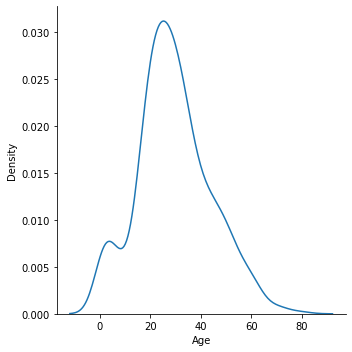

In [8]:
sns.displot(df_train, x="Age", kind="kde")

In [9]:
print(f"Mean {df_train['Age'].mean()}")
print(f"Median: {df_train['Age'].median()}")
print(f"Mode: {df_train['Age'].mode()[0]}")

Mean 29.498846153846156
Median: 28.0
Mode: 24.0


In [10]:
df_train = df_train.fillna({"Age": df_train["Age"].median()})
df_val = df_val.fillna({"Age": df_train["Age"].median()})
df_test = df_test.fillna({"Age": df_train["Age"].median()})

## Discretize Age

In [11]:
df_train["Age"] = pd.cut(df_train["Age"], bins=[0, 16, 32, 48, 64, 81], labels=False)
df_val["Age"] = pd.cut(df_val["Age"], bins=[0, 16, 32, 48, 64, 81], labels=False)
df_test["Age"] = pd.cut(df_test["Age"], bins=[0, 16, 32, 48, 64, 81], labels=False)

# Add FamilySize Feature

In [12]:
df_train["family_size"] = df_train["SibSp"] + df_train["Parch"] + 1
df_val["family_size"] = df_val["SibSp"] + df_val["Parch"] + 1
df_test["family_size"] = df_test["SibSp"] + df_test["Parch"] + 1

# Ticket, Name, Cabin

In [13]:
df_train = df_train.drop(["Ticket", "Name", "Cabin"], axis=1)
df_val = df_val.drop(["Ticket", "Name", "Cabin"], axis=1)
df_test = df_test.drop(["Ticket", "Name", "Cabin"], axis=1)

# Final data check

In [14]:
display(df_train)
display(df_train.info())

display(df_val)
display(df_val.info())


display(df_test)
display(df_test.info())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,family_size
331,332,0,1,2,0,0,28.5000,0,1,0,0,1,1
733,734,0,2,1,0,0,13.0000,0,1,0,0,1,1
382,383,0,3,1,0,0,7.9250,0,1,0,0,1,1
704,705,0,3,1,1,0,7.8542,0,1,0,0,1,2
813,814,0,3,0,4,2,31.2750,1,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,1,3,1,0,0,7.6500,1,0,0,0,1,1
270,271,0,1,1,0,0,31.0000,0,1,0,0,1,1
860,861,0,3,2,2,0,14.1083,0,1,0,0,1,3
435,436,1,1,0,1,2,120.0000,1,0,0,0,1,4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    int64  
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   sex_female   712 non-null    uint8  
 8   sex_male     712 non-null    uint8  
 9   embarked_C   712 non-null    uint8  
 10  embarked_Q   712 non-null    uint8  
 11  embarked_S   712 non-null    uint8  
 12  family_size  712 non-null    int64  
dtypes: float64(1), int64(7), uint8(5)
memory usage: 69.7 KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,family_size
709,710,1,3,1,1,1,15.2458,0,1,1,0,0,3
439,440,0,2,1,0,0,10.5000,0,1,0,0,1,1
840,841,0,3,1,0,0,7.9250,0,1,0,0,1,1
720,721,1,2,0,0,1,33.0000,1,0,0,0,1,2
39,40,1,3,0,1,0,11.2417,1,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,434,0,3,1,0,0,7.1250,0,1,0,0,1,1
773,774,0,3,1,0,0,7.2250,0,1,1,0,0,1
25,26,1,3,2,1,5,31.3875,1,0,0,0,1,7
84,85,1,2,1,0,0,10.5000,1,0,0,0,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 709 to 10
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Age          179 non-null    int64  
 4   SibSp        179 non-null    int64  
 5   Parch        179 non-null    int64  
 6   Fare         179 non-null    float64
 7   sex_female   179 non-null    uint8  
 8   sex_male     179 non-null    uint8  
 9   embarked_C   179 non-null    uint8  
 10  embarked_Q   179 non-null    uint8  
 11  embarked_S   179 non-null    uint8  
 12  family_size  179 non-null    int64  
dtypes: float64(1), int64(7), uint8(5)
memory usage: 17.5 KB


None

,PassengerId,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,family_size
0,892,3,2,0,0,7.8292,0,1,0,1,0,1
1,893,3,2,1,0,7.0000,1,0,0,0,1,2
2,894,2,3,0,0,9.6875,0,1,0,1,0,1
3,895,3,1,0,0,8.6625,0,1,0,0,1,1
4,896,3,1,1,1,12.2875,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,0,0,8.0500,0,1,0,0,1,1
414,1306,1,2,0,0,108.9000,1,0,1,0,0,1
415,1307,3,2,0,0,7.2500,0,1,0,0,1,1
416,1308,3,1,0,0,8.0500,0,1,0,0,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    int64  
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   sex_female   418 non-null    uint8  
 7   sex_male     418 non-null    uint8  
 8   embarked_C   418 non-null    uint8  
 9   embarked_Q   418 non-null    uint8  
 10  embarked_S   418 non-null    uint8  
 11  family_size  418 non-null    int64  
dtypes: float64(1), int64(6), uint8(5)
memory usage: 25.0 KB


None

# Fill missing Fare in test set

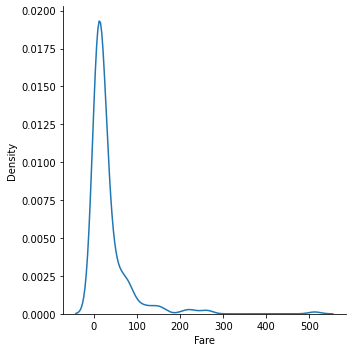

In [15]:
sns.displot(df_train, x="Fare", kind="kde")

In [16]:
print(f"Mean: {df_train['Fare'].mean()}")
print(f"Median: {df_train['Fare'].median()}")
print(f"Mode: {df_train['Fare'].mode()[0]}")

Mean: 32.5862761235955
Median: 14.4542
Mode: 8.05


In [17]:
df_test = df_test.fillna({"Fare": df_train["Fare"].median()}) # Fill up missing test Fare value with mode of train data

In [18]:
df_train['Survived'].value_counts().to_frame()

,Survived
0,444
1,268


# Data Split in train & test

In [19]:
x_train = df_train.drop(["PassengerId", "Survived"], axis=1)
y_train = df_train["Survived"].to_frame()

print("****************************** TRAIN DATA ***************************\n")
display(x_train)
display(y_train)


x_val = df_val.drop(["PassengerId", "Survived"], axis=1)
y_val = df_val["Survived"].to_frame()

print("\n\n****************************** VAL DATA ***************************\n")
display(x_val)
display(y_val)


x_test = df_test.drop(["PassengerId"], axis=1)
x_passenger_ids = df_test["PassengerId"].to_frame()

print("\n\n****************************** TEST DATA ***************************\n")
display(x_test)
display(x_passenger_ids)


****************************** TRAIN DATA ***************************



,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,family_size
331,1,2,0,0,28.5000,0,1,0,0,1,1
733,2,1,0,0,13.0000,0,1,0,0,1,1
382,3,1,0,0,7.9250,0,1,0,0,1,1
704,3,1,1,0,7.8542,0,1,0,0,1,2
813,3,0,4,2,31.2750,1,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...
106,3,1,0,0,7.6500,1,0,0,0,1,1
270,1,1,0,0,31.0000,0,1,0,0,1,1
860,3,2,2,0,14.1083,0,1,0,0,1,3
435,1,0,1,2,120.0000,1,0,0,0,1,4


,Survived
331,0
733,0
382,0
704,0
813,0
...,...
106,1
270,0
860,0
435,1




****************************** VAL DATA ***************************



,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,family_size
709,3,1,1,1,15.2458,0,1,1,0,0,3
439,2,1,0,0,10.5000,0,1,0,0,1,1
840,3,1,0,0,7.9250,0,1,0,0,1,1
720,2,0,0,1,33.0000,1,0,0,0,1,2
39,3,0,1,0,11.2417,1,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
433,3,1,0,0,7.1250,0,1,0,0,1,1
773,3,1,0,0,7.2250,0,1,1,0,0,1
25,3,2,1,5,31.3875,1,0,0,0,1,7
84,2,1,0,0,10.5000,1,0,0,0,1,1


,Survived
709,1
439,0
840,0
720,1
39,1
...,...
433,0
773,0
25,1
84,1




****************************** TEST DATA ***************************



,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,family_size
0,3,2,0,0,7.8292,0,1,0,1,0,1
1,3,2,1,0,7.0000,1,0,0,0,1,2
2,2,3,0,0,9.6875,0,1,0,1,0,1
3,3,1,0,0,8.6625,0,1,0,0,1,1
4,3,1,1,1,12.2875,1,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,0,0,8.0500,0,1,0,0,1,1
414,1,2,0,0,108.9000,1,0,1,0,0,1
415,3,2,0,0,7.2500,0,1,0,0,1,1
416,3,1,0,0,8.0500,0,1,0,0,1,1


,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


# PCA

Explained variance ration: [0.26048806 0.20266692]


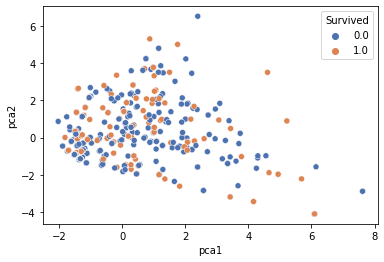

In [20]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(StandardScaler().fit_transform(x_train, y_train))

principalDf = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2'])

finalPrincipalDf = pd.concat([principalDf, y_train[['Survived']]], axis = 1)

sns.scatterplot(data=finalPrincipalDf, x="pca1", y="pca2", hue="Survived", palette="deep")
print(f"Explained variance ration: {pca.explained_variance_ratio_}")

In [21]:
def grid_search(model, params, x_train, y_train):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    pipeline = make_pipeline(StandardScaler(), model)
    
    cv = GridSearchCV(pipeline, param_grid=params, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
    cv.fit(x_train.to_numpy(), y_train.values.ravel())
    
    model = cv.best_estimator_[1]
    score = cv.best_score_
    
    print(f"Training: {score:.4f} {model}")
    
    return score, model

def evaluate(model, x_train, y_train, x_val, y_val):
    scaler = StandardScaler().fit(x_train, y_train)
    
    _x_train = scaler.transform(x_train)
    _x_val = scaler.transform(x_val)
        
    model = model.fit(_x_train, y_train.values.ravel())
    score = model.score(_x_val, y_val.values.ravel())
    
    print(f"Evaluation: {score:.4f} {model}")
    
    return score, model

def get_test_predictions(model, x_train, y_train, x_val, y_val, x_test):
    _, model = evaluate(model, x_train, y_train, x_val, y_val)
    
    scaler = StandardScaler().fit(x_train, y_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    model = model.fit(x_train, y_train.values.ravel())
    
    return model.predict(x_test)

# Baseline Classifier

In [22]:
train_score, model = grid_search(DummyClassifier(random_state=42), {}, x_train, y_train)
val_score, model = evaluate(model, x_train, y_train, x_val, y_val)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Training: 0.6236 DummyClassifier(random_state=42)
Evaluation: 0.5866 DummyClassifier(random_state=42)


In [23]:
models = []

# KNN

In [24]:
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 200, 1),
    'kneighborsclassifier__weights': ["uniform", "distance"]
}

train_score, model = grid_search(KNeighborsClassifier(), param_grid, x_train, y_train)
val_score, model = evaluate(model, x_train, y_train, x_val, y_val)

Fitting 10 folds for each of 398 candidates, totalling 3980 fits
Training: 0.8301 KNeighborsClassifier(n_neighbors=13)
Evaluation: 0.7933 KNeighborsClassifier(n_neighbors=13)


In [25]:
models.append({
    "type": "KNN",
    "model": model,
    "val_score": val_score,
    "train_score": train_score
})

# Random Forest

In [26]:
param_grid = {
    'randomforestclassifier__max_depth': np.arange(1, 8, 1),
    'randomforestclassifier__n_estimators': np.arange(5, 100, 1)
}

train_score, model = grid_search(RandomForestClassifier(random_state=42), param_grid, x_train, y_train)
val_score, model = evaluate(model, x_train, y_train, x_val, y_val)

Fitting 10 folds for each of 665 candidates, totalling 6650 fits
Training: 0.8302 RandomForestClassifier(max_depth=5, n_estimators=76, random_state=42)
Evaluation: 0.8101 RandomForestClassifier(max_depth=5, n_estimators=76, random_state=42)


In [27]:
models.append({
    "type": "RandomForest",
    "model": model,
    "val_score": val_score,
    "train_score": train_score
})

# GradientBoostingClassifier

In [28]:
param_grid = {
    'gradientboostingclassifier__learning_rate': np.arange(0.2, 0.85, 0.15),
    'gradientboostingclassifier__n_estimators': np.arange(1, 80, 2),
    'gradientboostingclassifier__max_depth': np.arange(1, 7, 1)
}

train_score, model = grid_search(GradientBoostingClassifier(random_state=42), param_grid, x_train, y_train)
val_score, model = evaluate(model, x_train, y_train, x_val, y_val)

Fitting 10 folds for each of 1200 candidates, totalling 12000 fits
Training: 0.8344 GradientBoostingClassifier(learning_rate=0.2, n_estimators=13, random_state=42)
Evaluation: 0.7989 GradientBoostingClassifier(learning_rate=0.2, n_estimators=13, random_state=42)


In [29]:
models.append({
    "type": "GradientBoosting",
    "model": model,
    "val_score": val_score,
    "train_score": train_score
})

# SVM

In [30]:
param_grid = {
    'svc__C': np.arange(0.01, 1, 0.01),
    'svc__gamma':  list(np.arange(0.01, 1, 0.1)) + ['scale', 'auto']
}

train_score, model = grid_search(SVC(random_state=42), param_grid, x_train, y_train)
val_score, model = evaluate(model, x_train, y_train, x_val, y_val)

Fitting 10 folds for each of 1188 candidates, totalling 11880 fits
Training: 0.8259 SVC(C=0.42000000000000004, gamma=0.11, random_state=42)
Evaluation: 0.8156 SVC(C=0.42000000000000004, gamma=0.11, random_state=42)


In [31]:
models.append({
    "type": "SVM",
    "model": model,
    "val_score": val_score,
    "train_score": train_score
})

# AdaBoost

In [32]:
param_grid = {
    'adaboostclassifier__n_estimators': np.arange(50, 150, 1),
    'adaboostclassifier__learning_rate': np.arange(0.4, 1, 0.1)
}

train_score, model = grid_search(AdaBoostClassifier(random_state=42), param_grid, x_train, y_train)
val_score, model = evaluate(model, x_train, y_train, x_val, y_val)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Training: 0.8175 AdaBoostClassifier(learning_rate=0.7999999999999999, n_estimators=90,
                   random_state=42)
Evaluation: 0.7933 AdaBoostClassifier(learning_rate=0.7999999999999999, n_estimators=90,
                   random_state=42)


In [33]:
models.append({
    "type": "AdaBoost",
    "model": model,
    "val_score": val_score,
    "train_score": train_score
})

In [34]:
models.sort(key=lambda x: x['val_score'], reverse=True)
models

[{'type': 'SVM',
  'model': SVC(C=0.42000000000000004, gamma=0.11, random_state=42),
  'val_score': 0.8156424581005587,
  'train_score': 0.8259389671361502},
 {'type': 'RandomForest',
  'model': RandomForestClassifier(max_depth=5, n_estimators=76, random_state=42),
  'val_score': 0.8100558659217877,
  'train_score': 0.8301838810641629},
 {'type': 'GradientBoosting',
  'model': GradientBoostingClassifier(learning_rate=0.2, n_estimators=13, random_state=42),
  'val_score': 0.7988826815642458,
  'train_score': 0.8343896713615024},
 {'type': 'KNN',
  'model': KNeighborsClassifier(n_neighbors=13),
  'val_score': 0.7932960893854749,
  'train_score': 0.8300860719874803},
 {'type': 'AdaBoost',
  'model': AdaBoostClassifier(learning_rate=0.7999999999999999, n_estimators=90,
                     random_state=42),
  'val_score': 0.7932960893854749,
  'train_score': 0.817527386541471}]

In [35]:
possible_voting_estimators = list(map(lambda x: (x['type'], x['model']), models))
possible_voting_estimator_combinations = list(itertools.combinations(possible_voting_estimators, 1)) + list(itertools.combinations(possible_voting_estimators, 3)) + list(itertools.combinations(possible_voting_estimators, 5))
possible_voting_estimator_combinations

[(('SVM', SVC(C=0.42000000000000004, gamma=0.11, random_state=42)),),
 (('RandomForest',
   RandomForestClassifier(max_depth=5, n_estimators=76, random_state=42)),),
 (('GradientBoosting',
   GradientBoostingClassifier(learning_rate=0.2, n_estimators=13, random_state=42)),),
 (('KNN', KNeighborsClassifier(n_neighbors=13)),),
 (('AdaBoost',
   AdaBoostClassifier(learning_rate=0.7999999999999999, n_estimators=90,
                      random_state=42)),),
 (('SVM', SVC(C=0.42000000000000004, gamma=0.11, random_state=42)),
  ('RandomForest',
   RandomForestClassifier(max_depth=5, n_estimators=76, random_state=42)),
  ('GradientBoosting',
   GradientBoostingClassifier(learning_rate=0.2, n_estimators=13, random_state=42))),
 (('SVM', SVC(C=0.42000000000000004, gamma=0.11, random_state=42)),
  ('RandomForest',
   RandomForestClassifier(max_depth=5, n_estimators=76, random_state=42)),
  ('KNN', KNeighborsClassifier(n_neighbors=13))),
 (('SVM', SVC(C=0.42000000000000004, gamma=0.11, random_sta

In [36]:
param_grid = {
    'votingclassifier__estimators': possible_voting_estimator_combinations
}

train_score, model = grid_search(VotingClassifier(estimators=[]), param_grid, x_train, y_train)
val_score, model = evaluate(model, x_train, y_train, x_val, y_val)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Training: 0.8414 VotingClassifier(estimators=(('RandomForest',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=76,
                                                     random_state=42)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         n_estimators=13,
                                                         random_state=42)),
                             ('KNN', KNeighborsClassifier(n_neighbors=13))))
Evaluation: 0.8101 VotingClassifier(estimators=(('RandomForest',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=76,
                                                     random_state=42)),
                             ('GradientB

In [37]:
y_test_pred = get_test_predictions(model, x_train, y_train, x_val, y_val, x_test)

x_passenger_ids["Survived"] = y_test_pred
x_passenger_ids['Survived'].value_counts()

Evaluation: 0.8101 VotingClassifier(estimators=(('RandomForest',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=76,
                                                     random_state=42)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         n_estimators=13,
                                                         random_state=42)),
                             ('KNN', KNeighborsClassifier(n_neighbors=13))))


0    279
1    139
Name: Survived, dtype: int64

In [38]:
x_passenger_ids.to_csv(f"submission.csv", index=False)